<div style="text-align: center;"><br>
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

## Constructing Circuits 

In this section we will explore building quantum circuits in pytket with the `Circuit` class and introduce some useful circuit primitives.

At the end, we'll briefly cover some circuit optimisation

### Basic Bell circuit

In pytket we can create an instance of the `Circuit` class and add gates sequentially. We can prepare an entangled Bell state using a Hadamard and a CX gate

$$
\begin{equation}
\text{H} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\,, 
\quad
CX=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}
$$

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter as draw

h_circ = Circuit(1)

h_circ.H(0)
draw(h_circ)

In [2]:
h_circ.get_unitary().round(3)

array([[ 0.707+0.j,  0.707+0.j],
       [ 0.707+0.j, -0.707+0.j]])

In [3]:
bell_circ = Circuit(2, name="Bell")
bell_circ.H(0)
bell_circ.CX(0, 1)
draw(bell_circ)

In [4]:
bell_circ.get_statevector()

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Compare with the equation below...


$$
\begin{equation}
|\psi \rangle = \frac{1}{\sqrt{2}} \big(|00 \rangle + | 11 \rangle  \big)\,, \qquad \frac{1}{\sqrt{2}} \approx 0.707...
\end{equation}
$$

In [5]:
bell_circ.measure_all()
draw(bell_circ)

In [6]:
from pytket.extensions.nexus import AerConfig, NexusBackend, Nexus
from pytket.extensions.nexus.visualisation import plot_results_histogram

nexus = Nexus()

nexus.new_project("basic_simulation_japan")

aer_backend = NexusBackend(AerConfig(), project_name="basic_simulation_japan")
result = aer_backend.run_circuit(bell_circ, n_shots=1000)
print(result.get_counts())


New project created: basic simulation

Started using project with name: basic simulation
Counter({(0, 0): 505, (1, 1): 495})


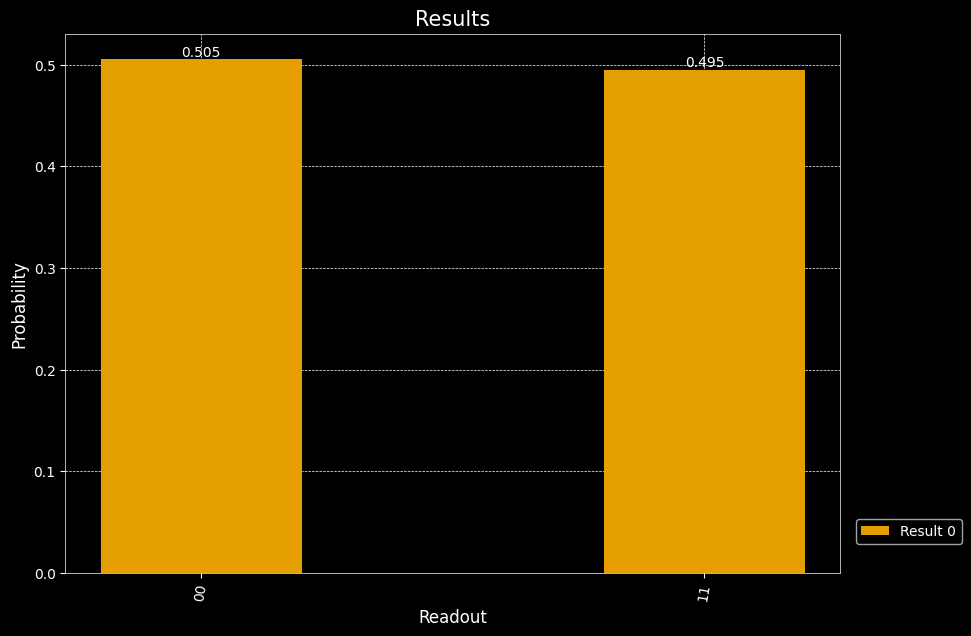

In [8]:
plot_results_histogram([result])

Some pytket gates are only available through the `OpType` enum.

For an exhasutive list of all pytket operations, see the docs -> https://tket.quantinuum.com/api-docs/optype.html

In [ ]:
from pytket import OpType

circ = Circuit(3)

circ.add_gate(OpType.CnZ, [0, 1, 2])
draw(circ)

In [ ]:
circ.get_unitary().shape

In [ ]:
circ.get_unitary()

In [ ]:
circ.get_unitary().diagonal()

## Symbolic Circuits



In [ ]:
from sympy import symbols

a, b, c = symbols("a b c")

symb_circ = Circuit(1).Rz(a, 0).Rx(b, 0).Rz(c, 0)
draw(symb_circ)

In [ ]:
from pytket.utils.symbolic import circuit_to_symbolic_unitary

circuit_to_symbolic_unitary(symb_circ)

### Constructing a Circuit from QASM

* OpenQASM 2.0 (Open Quantum assembly language provides a low level specification of quantum circuits)
* We Can easily build a circuit from a QASM file (And also export a circuit to QASM)

In [ ]:
from pytket.qasm import circuit_from_qasm

w_state_circ = circuit_from_qasm("qasm/W-state.qasm")
draw(w_state_circ)

### Import a circuit from Qiskit (or other SDKs)

Its possible to generate a circuit directly from a Qiskit `QuantumCircuit` using the [qiskit_to_tk](https://tket.quantinuum.com/extensions/pytket-qiskit/api.html#pytket.extensions.qiskit.tk_to_qiskit) function.

To run this in your local environment, run `pip install pytket-qiskit`. 

To see all extensions pytket supports, visit: https://tket.quantinuum.com/api-docs/extensions#pytket-extensions. 

In [ ]:
from qiskit import QuantumCircuit

qiskit_circ = QuantumCircuit(3)
qiskit_circ.h(range(3))
qiskit_circ.ccx(2, 1 ,0)
qiskit_circ.cx(0, 1)
print(qiskit_circ)

In [ ]:
from pytket.extensions.qiskit import qiskit_to_tk

tket_circ = qiskit_to_tk(qiskit_circ)

draw(tket_circ)

## A more interesting Circuit - The Quantum Fourier Transform

Lets build a `Circuit` to implement the Quantum Fourier Transform. This an important subroutine in many quantum algorithms including factoring and fault tolerant approaches to quantum chemistry.

Mathematically, the $QFT$ has the following action.

$$
\begin{equation}
QFT : |j\rangle\ \longmapsto \frac{1}{\sqrt{N}} \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle, \quad N= 2^n
\end{equation}
$$

This is essentially the Discrete Fourier transform except the input is a quantum state $|j\rangle$.

We can build the circuit for the $n$ qubit $QFT$ using $n$ Hadamard gates $\lfloor{\frac{n}{2}}\rfloor$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations $\text{CU1}$.

$$
 \begin{equation}
U1(\phi) =
 \begin{pmatrix}
 1 & 0 \\
 0 & e^{i \pi \phi}
 \end{pmatrix}\, , \quad
 CU1(\phi) =
 \begin{pmatrix}
 1 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 \\
 0 & 0 & 1 & 0 \\
 0 & 0 & 0 & e^{i \pi \phi}
 \end{pmatrix}
 \end{equation}
$$

The circuit for the Quantum Fourier transform on three qubits is the following

![](images/qft_dark.png)


We can build this circuit in `pytket` by adding gate operations manually:

In [ ]:
qft3_circ = Circuit(3, name="QFT")
qft3_circ.H(0)
qft3_circ.CU1(0.5, 1, 0)
qft3_circ.CU1(0.25, 2, 0)
qft3_circ.H(1)
qft3_circ.CU1(0.5, 2, 1)
qft3_circ.H(2)
qft3_circ.SWAP(0, 2)
draw(qft3_circ)

## Boxes in pytket

In [ ]:
from pytket.circuit import CircBox


qft3_box = CircBox(qft3_circ)

In [ ]:
circ = Circuit(3)
circ.X(0).X(1).X(2)
circ.add_gate(qft3_box, [0, 1, 2])

draw(circ)

We can build the $QFT$ for $n$ qubits as follows...

In [ ]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [ ]:
draw(build_qft_circuit(4))

### Circuit Boxes (II)

* Often we will need synthesise a quantum circuit to implement a given unitary
* Unitary synthesis is supported by TKET (Up to 3 qubits)
* **Fact:** A two-qubit unitary can be implemented with at most 3 CX gates (KAK decomposition)



In [ ]:
from pytket.circuit import Unitary2qBox
from scipy.stats import unitary_group

random_su4_unitary = unitary_group.rvs(4)

u2_box = Unitary2qBox(random_su4_unitary)

test_circ = Circuit(2)
test_circ.add_unitary2qbox(u2_box, 0, 1)

draw(test_circ)

In [ ]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(test_circ)  # Decompose the box in place

draw(test_circ)  # view raw circuit 

## Useful circuit primitives

Here are a list of circuit subroutines that you might find useful when building circuits

* [CircBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.CircBox) - Allows you define higher level subroutines using a `Circuit` which can then be reused in complex circuits and algorithms.

* [QControlBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.QControlBox) - Construct custom controlled gates in pytket using any base unitary operation. See the manual section on [controlled gates](https://tket.quantinuum.com/user-manual/manual_circuit.html#controlled-box-operations)

* [Unitary2qBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.Unitary2qBox) - Allows you to generate an `Circuit` to implement an arbitrary 2 qubit operation. Unitary synthesis also available for 1 and 3 qubit operations. See the [manual section](https://tket.quantinuum.com/user-manual/manual_circuit.html#boxes-for-unitary-synthesis) for usage.

* [StatePreparationBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.StatePreparationBox) - Allows preparation of an arbitary quantum state using a naive algorithm. See [the docs](https://tket.quantinuum.com/user-manual/manual_circuit.html#multiplexors-state-preperation-boxes-and-toffolibox) for more. 


## Other useful resources on Circuit construction

* [Circuit construction section of the user manual](https://tket.quantinuum.com/user-manual/manual_circuit.html)

* Example notebook on [Quantum Phase Estimation](https://tket.quantinuum.com/examples/phase_estimation.html) Show's the use of several circuit primitives to build circuits for quantum phase estimation

## Basic circuit rewrites


### Rebases (converting a circuit to a desired gateset)

Before you can run a circuit on a quantum device you have to convert the circuit to the gateset supported by the device. In pytket this conversion is called a rebase

Here's a basic example converting our Bell state circuit to the native gates of an IBM device


In [ ]:
from pytket.passes.auto_rebase import auto_rebase_pass

ibm_rebase = auto_rebase_pass({OpType.X, OpType.SX, OpType.Rz, OpType.ECR})

ibm_rebase.apply(bell_circ)

draw(bell_circ)

## Peephole Optimisation

A rebase pass is useful for converting to the native gateset of the target device.

However circuit optimistaion is another important part of a quantum compiler. This can have a big impact on circuit fidelity as we shall see.

Lets try optimising a circuit from quantum chemistry with the general purpose `FullPeepholeOptimise` pass

In [ ]:
jw_chem_circ = circuit_from_qasm("qasm/H2JordanWignerMapper.qasm")
draw(jw_chem_circ)

print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

In [ ]:
from pytket.passes import FullPeepholeOptimise

FullPeepholeOptimise().apply(jw_chem_circ)

draw(jw_chem_circ)
print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>